In [1]:
import torch
import deepwave
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import scipy
import random

from tqdm import tqdm

In [2]:
def normalized_shot_gather(csg):
    max_amp = torch.max(torch.abs(csg), dim=-1, keepdim=True)[0]
    normalized_csg = csg / (max_amp + 1e-10)
    return normalized_csg

In [3]:
offset = 5
src_spacing = 16
n_gp = 24
gp_spacing = 1

x_m = 45
z_m = 20
dx = 0.2

nx = int(x_m/dx)
nz = int(z_m/dx)

In [4]:
shots = torch.tensor([5, 21, 38]).to(device=device)/dx
receiver = torch.arange(10, 34, gp_spacing).to(device=device)/dx

In [5]:
vs_back = 200
vp_back = 500
rho_back = 1800

vs_obs = 0.1
vp_obs = 340
rho_obs =1000

In [6]:
fs = 1000
dt = 1/fs
t= 0.5
nt = int(t/dt)
time = np.arange(0, dt * nt, dt)

In [7]:
x= np.arange(0, x_m, dx)
z= np.arange(0, z_m, dx)
X, Z = np.meshgrid(x, z)

circle_center_x = x_m / 2  # x 중심
circle_center_z = 3  # 깊이 10m
circle_radius = 1  # 반지름 5m

# 장애물 영역 계산
circle_mask = (X - circle_center_x) ** 2 + (Z - circle_center_z) ** 2 <= circle_radius ** 2

vp_circle = torch.ones((nz, nx), device=device) * vp_back
vs_circle = torch.ones((nz, nx), device=device) * vs_back
rho_circle = torch.ones((nz, nx), device=device) * rho_back

vp_circle[circle_mask] = vp_obs
vs_circle[circle_mask] = vs_obs
rho_circle[circle_mask] = rho_obs

In [8]:
rho_circle[circle_mask] = rho_obs
V_MAX = 300
V_MIN = 0
data_range = V_MAX - V_MIN

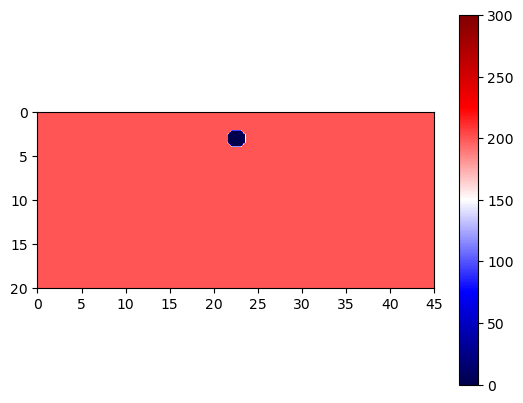

In [9]:
plt.figure()
plt.imshow(vs_circle.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar() 
plt.show()


In [10]:
vp_f, vs_inv, rho_f = torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device)
vp_f[:,:] = vp_back
vs_inv[:,:] = vs_back
rho_f[:,:] = rho_back

In [11]:
n_shots = len(shots)
n_sources_per_shot = 1

f0 = 20
peak_time = 1.5/f0

source_amplitudes = (
    (deepwave.wavelets.ricker(f0, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

shot = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
shot[..., 0] = 2
shot[..., 1] = (shots).unsqueeze(1)

In [12]:
receiver_locations = torch.zeros(n_shots, len(receiver), 2, dtype=torch.long, device=device)
receiver_locations[..., 0] = 0
receiver_locations[:, :, 1] = receiver

In [13]:
obs = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_circle, vs_circle, rho_circle),
    grid_spacing=dx, dt=dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=shot,
    receiver_locations_y=receiver_locations,
    pml_freq=f0, pml_width=[0, 10, 10, 10]
)[-2]
obs = normalized_shot_gather(obs)

C:\Anaconda3\envs\FWI\Lib\site-packages\deepwave\common.py:399: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 20, a minimum velocity of 0.10000000894069672, and a grid cell spacing of 0.2, there are only 0.025000002235174176.
  warnings.warn("At least six grid cells per wavelength is "


In [14]:
print(obs)

tensor([[[ 8.3604e-06, -1.9041e-06,  1.0505e-06,  ..., -1.2758e-05,
          -1.5990e-06,  1.3624e-05],
         [ 2.0699e-05, -4.3161e-06,  2.2973e-06,  ...,  4.3112e-05,
           4.3947e-05,  5.3931e-05],
         [ 1.4766e-05, -3.0604e-06,  1.6479e-06,  ...,  5.0627e-05,
           4.3206e-05,  4.2338e-05],
         ...,
         [ 5.9142e-06, -1.1844e-06,  6.3833e-07,  ...,  1.4966e-05,
           1.3720e-05,  1.5812e-05],
         [ 8.3700e-06, -1.7531e-06,  9.7740e-07,  ...,  3.2758e-05,
           2.6328e-05,  2.4357e-05],
         [ 1.9054e-05, -3.9287e-06,  2.1671e-06,  ...,  5.7842e-05,
           5.1679e-05,  5.3147e-05]],

        [[ 2.4906e-06, -5.6347e-07,  3.4318e-07,  ...,  7.8735e-06,
           6.9294e-06,  6.5848e-06],
         [ 2.2703e-06, -4.5107e-07,  2.2105e-07,  ...,  5.4427e-06,
           4.5286e-06,  5.6286e-06],
         [ 3.1851e-06, -5.9757e-07,  3.4659e-07,  ...,  7.7199e-06,
           7.5645e-06,  8.5199e-06],
         ...,
         [ 2.1144e-06, -4

In [15]:
def csg(
    data, receiver, time,
    duration: float,
    title: str,
    color=None,
    second_data=None,
    second_color=None,
    show_legend: bool = True
):
    # numpy 변환
    if hasattr(data, 'detach'):
        data = data.detach().cpu().numpy()
    if second_data is not None and hasattr(second_data, 'detach'):
        second_data = second_data.detach().cpu().numpy()
    if hasattr(receiver, 'detach'):
        receiver = receiver.detach().cpu().numpy()

    dt      = time[1] - time[0]
    max_idx = int(duration / dt)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # 합성파
    for i in range(data.shape[0]):
        trace = data[i, :max_idx]
        norm  = trace / np.max(np.abs(trace))
        ax.plot(receiver[i] + norm, time[:max_idx],
                color=color)

    # 관측파
    if second_data is not None:
        for i in range(second_data.shape[0]):
            trace = second_data[i, :max_idx]
            norm  = trace / np.max(np.abs(trace))
            ax.plot(receiver[i] + norm, time[:max_idx],
                    color=second_color, linestyle='--')

    ax.invert_yaxis()
    ax.set_xlabel("Offset (m)")
    ax.set_ylabel("Time (s)")
    ax.set_title(title)
    if show_legend == True:
        ax.legend(loc='lower right')

    ax.grid(True)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    plt.show()

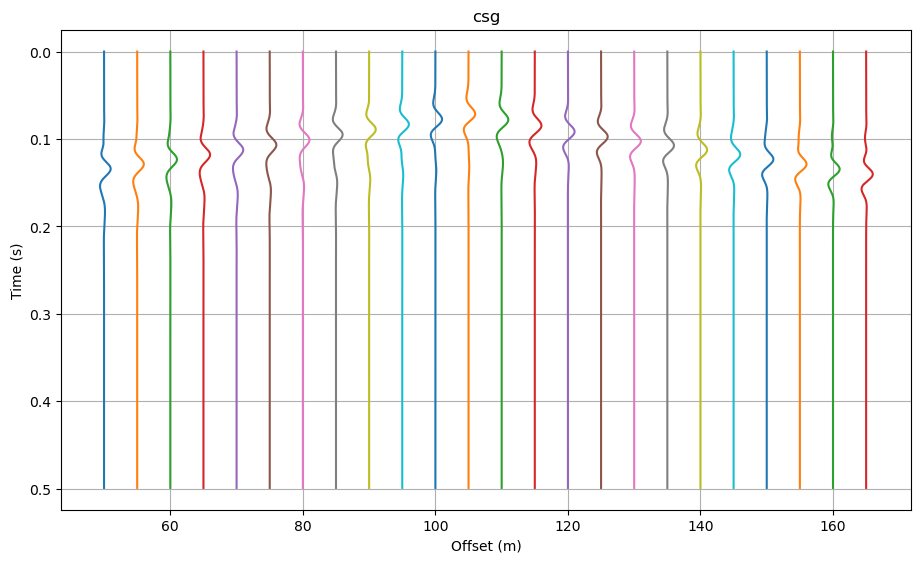

In [16]:
csg(obs[1, :, :], receiver, time, duration=1, title="csg", show_legend=False)

In [17]:
vs_c = vs_inv.clone()
vs_c.requires_grad = True

In [22]:
n_epoch = 10000
lr = 1e-2
optimizer_c = torch.optim.Adam([vs_c], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_c,
    mode='min',
    factor=0.5,
    patience=5,
)
loss_fn = torch.nn.MSELoss()
losses = []
vs_c_list = []
alpha_tv = 1e-6

In [23]:
def total_variation(tensor, dx, dz, eps=1e-6):
    """
    tensor: shape [1, nz, nx]
    returns scalar TV loss
    """
    dz_tensor = (tensor[:, 1:, :] - tensor[:, :-1, :]) / dz  # [1, nz-1, nx]
    dx_tensor = (tensor[:, :, 1:] - tensor[:, :, :-1]) / dx  # [1, nz, nx-1]

    dz_pad = F.pad(dz_tensor, (0,0,0,1), mode='replicate')  # pad bottom
    dx_pad = F.pad(dx_tensor, (0,1,0,0), mode='replicate')  # pad right

    tv = torch.sqrt(dx_pad**2 + dz_pad**2 + eps)
    return tv.mean()

In [24]:
for epoch in tqdm(range(n_epoch)):
    torch.cuda.empty_cache()
    optimizer_c.zero_grad()
    syn = deepwave.elastic(
        *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_c, rho_f),
        grid_spacing=dx, dt=dt,
        source_amplitudes_y=source_amplitudes,
        source_locations_y=shot,
        receiver_locations_y=receiver_locations,
        pml_freq=f0, pml_width=[0, 10, 10, 10]
    )[-2]
    syn = normalized_shot_gather(syn)
    tv_reg = alpha_tv * total_variation(vs_c.unsqueeze(0), dx, dx)
    loss = loss_fn(syn, obs) + tv_reg
    losses.append(loss.item())
    loss.backward()
    if vs_c.grad is not None:
            torch.nn.utils.clip_grad_value_(vs_c, torch.quantile(vs_c.grad.detach().abs(), 0.98))
    optimizer_c.step()
    scheduler.step(loss.item())
    
            
    if epoch % 1000 == 0:
        vs_c_list.append(vs_c.detach().cpu().numpy())

100%|██████████| 10000/10000 [1:44:46<00:00,  1.59it/s]


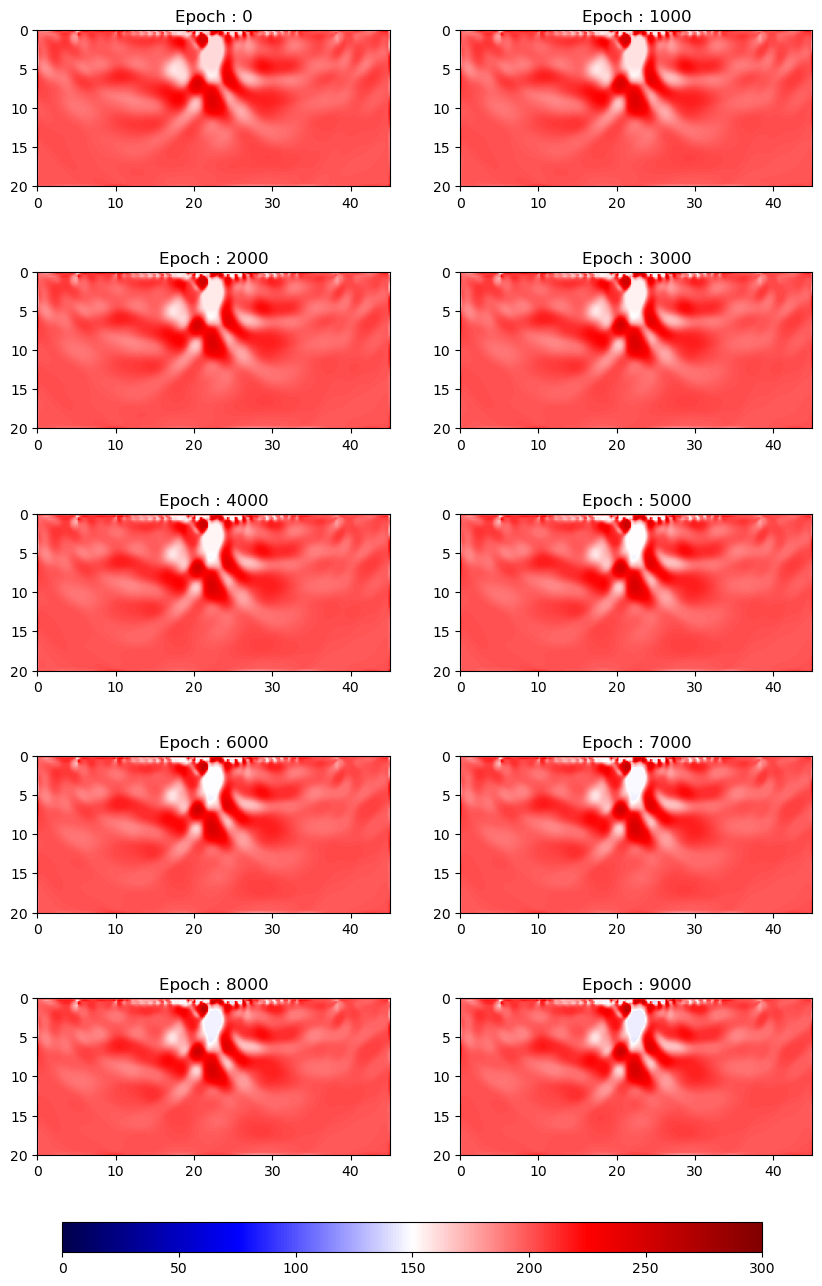

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
fig.subplots_adjust(bottom=0.1)

im = None
for i, ax in enumerate(axes.flat):
    if i < len(vs_c_list):
        data_to_plot = vs_c_list[i]

        im = ax.imshow(data_to_plot,
                       cmap='seismic',
                       aspect='equal',
                       extent=[0, nx*dx, nz*dx, 0],
                       vmax=V_MAX,
                       vmin=V_MIN)

        # 제목의 'Number of Shots' 부분이 0부터 시작하도록 수정
        ax.set_title(f"Epoch : {i * 1000}")

    else:
        ax.axis('off')

# --- 컬러바를 위한 전용 축(cax) 생성 및 컬 러바 그리기 ---
if im:
    # add_axes로 컬러바가 그려질 위치와 크기를 직접 지정합니다.
    # [left, bottom, width, height] 형식이며, 전체 그림에 대한 비율입니다.
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()